# EMLET laboratory excercise

### Requirements
The laboratory excercise needs to be performed in JupyterLab envrinoment (https://jupyter.org). 

Moreover, Python 3.x is required with the following packages:
- scikit learn Machine Learning library in Python https://scikit-learn.org
- matplotlib library for creating visualization in Python https://matplotlib.org/
- pandas Python Data Analysis Library https://pandas.pydata.org/
- graphviz graph drawing software https://pypi.org/project/graphviz/
You can simple use Anaconda Python distribution for data science: https://www.anaconda.com/ to obtain all these packages in one step.

## Dataset description
The dataset refers to video streaming service. The data is a small subset of data that has been measured in KHT University (Stokholm) testbed, where HTTP Video-on-Demand (VoD) service with VLC clients has been monitored. The performance indicators on the client side refer to service-level metrics, for example, frame rate and response time. Moreover, the performance indicators on infrastucture have been collected, and show low-level device statistics, such as number of users handled by streaming server, system calls, ratio of software components called, server idle resources. The metrics "infrastructure-level" and "service-level" evolve over time, influenced, e.g., by the load on the streaming servers, operating system dynamics, network traffic, number of active clients. Assuming a
global clock that can be read on the streaming servers, in the network devices, and in the VLC clients, we can model the evolution of the metrics "infrastructure-level" and "service-level" as time series. Data is collected every second over a period of 5000 seconds.

There are two datasets that differ in the pattern of data generation:
- Periodic-load Pattern: Generator produces the load of VoD service following a Poisson process. Its arrival rate is modulated by a sinusoidal function.
- Flashcrowd-load Pattern: Generator produces the load of VoD service following a Poisson process whose arrival rate is modulated by a flashcrowd model (the arrival rate starts at value 'FS' and peaks at flash events; 'FE' such events occur within an hour, distributed uniformly at random over this time period; at each flash event, the arrival rate increases within a minute to a peak value of 'FR', stays at this level for one minute, and then decreases to the initial rate within four minutes).

The datasets are provided by email as ZIP archive which contains two csv files (separately for "infrastructure-level" and "service-level"):
- Vod metrics with periodic pattern: vod-periodic.zip 
- Vod metrics with Flashcrowd pattern: vod-flashcrowd.zip

## Laboratory excercise
The aim of the exercise is to familiarise you with Python tools for ML. Your task is to see if it is possible to learn service-level metrics from infrastructure statistics using standard machine-learning methods. Our target application performance indicator is indicated in email (as "target variable").

### Task 1
Using 'read_csv()' function from pandas Python package, load dataset indicated in email as pandas DataFrame objects, analyse it and shortly characterize it in text cell below (you can create histograms or time-series for most interesting variables).
Hint: you can use DataFrame info() function, or print DataFrame object
Hint2: you can visualize data using DataFrame.plot.scatter() function from pandas
Hint3: for time-series visualisation, you use integers: 1, 2, 3, 4, ... as X-axis values (why can you do it this way?) 

Notes:
- noAudioPlayed = Number of audio frames played
- AvgInterAudioPlayedDelay = Average audio play delay
- NetReadAvgDelay = value of network read average delay
- AvgInterDispDelay = Average display delay
- DispFrames = Display Frame Rate (per second)

---
First I perform data import. The delay values are converted into ms, as they are usually measured in that unit

In [247]:
import pandas as pd
pd.options.display.width = 160

import matplotlib.pyplot as plt
csv_data = pd.read_csv('service-metrics_vod-flashcrowd.csv')
# csv_data.TimeStamp = pd.to_datetime(csv_data.TimeStamp)  # Converting to a time format might be a good idea. Otherwise, it's string

# Convert to ms
csv_data.avgInterAudioPlayedDelay *= 1000
csv_data.NetReadAvgDelay *= 1000
csv_data.AvgInterDispDelay *= 1000

csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                5000 non-null   int64  
 1   TimeStamp                 5000 non-null   object 
 2   LostFrames                5000 non-null   int64  
 3   noAudioPlayed             5000 non-null   int64  
 4   avgInterAudioPlayedDelay  5000 non-null   float64
 5   NetReadOperations         5000 non-null   int64  
 6   NetReadBytes              5000 non-null   int64  
 7   NetReadAvgDelay           5000 non-null   float64
 8   noAudioLost               5000 non-null   int64  
 9   noAudioLate               5000 non-null   int64  
 10  DispFrames                5000 non-null   int64  
 11  AvgInterDispDelay         5000 non-null   float64
dtypes: float64(3), int64(8), object(1)
memory usage: 468.9+ KB


# Data analysis
## Outliers - packet transmission scenarios & issues
As in any data, outliers and patterns are present. For our dataset, they are caused by breaks in the transmission of the VOD material. These breaks are caused by the server being overloaded. 3 main scenarios are discussed below - whenever packet transmission is stopped or started after a longer break, and a scenario where interruptions are in short bursts.

### Packet transmission stop
The behavior is simpler than the start. At more or less the same moment all transmission related metrics: `NoAudioPlayed, avgInterAudioPlayedDelay, NetReadOperations, NetReadBytes` and `NetReadAvgDelay` become 0. Framerate stabilises to 13.

Below are shown 3 examples of such behavior:

In [248]:
# 481, 1573, 2140
print(csv_data[477:494][['noAudioPlayed','NetReadOperations', 'NetReadBytes', 'NetReadAvgDelay', 'DispFrames']])
print('-'*100)
print(csv_data[1569:1586][['noAudioPlayed','NetReadOperations', 'NetReadBytes', 'NetReadAvgDelay', 'DispFrames']])
print('-'*100)
print(csv_data[2136:2153][['noAudioPlayed','NetReadOperations', 'NetReadBytes', 'NetReadAvgDelay', 'DispFrames']])

     noAudioPlayed  NetReadOperations  NetReadBytes  NetReadAvgDelay  DispFrames
477             42                117         72960         8.407684          24
478             41                228         97344         4.421122          24
479             42                230        121632         4.487000          24
480             42                 89         42378         5.661180          24
481             41                  0             0         0.000000          24
482             42                  0             0         0.000000          24
483             42                  0             0         0.000000          24
484             33                  0             0         0.000000          24
485              0                  0             0         0.000000          24
486              0                  0             0         0.000000          24
487              0                  0             0         0.000000          15
488              0          

### Packet transmission start
When user decides to watch a VOD, certain metrics momentarily spike. These are:
1. NetReadAvgDelay spikes to >12000 ms
2. NetReadBytes and NetReadOperations spike
3. At the same time as previous, noAudioPlayed also can spike (although not always significantly)
4. Values stabilise to their usual values, framerate stabilises to 24
This behavior is shown by 3 excerpts from the csv table below

In [249]:
# 525, 1623, 2188
print(csv_data[521:538][['noAudioPlayed','NetReadOperations', 'NetReadBytes', 'NetReadAvgDelay', 'DispFrames']])
print('-'*100)
print(csv_data[1619:1636][['noAudioPlayed','NetReadOperations', 'NetReadBytes', 'NetReadAvgDelay', 'DispFrames']])
print('-'*100)
print(csv_data[2184:2201][['noAudioPlayed','NetReadOperations', 'NetReadBytes', 'NetReadAvgDelay', 'DispFrames']])


     noAudioPlayed  NetReadOperations  NetReadBytes  NetReadAvgDelay  DispFrames
521              0                  0             0         0.000000          13
522              0                  0             0         0.000000          13
523              0                  0             0         0.000000          13
524              0                  3             0     14668.879350           7
525             36               1317        814168         1.101233           8
526             32                880        711360         1.126038          21
527             32                888        692936         1.175837          23
528             68                590        334296         1.725816          24
529             48                115         73438         7.421975          24
530             42                 69         48632        16.694577          24
531             42                 59         40528        10.576729          24
532             43          

### Packet transmission consistent degradation
Perhaps the most interesting behavior that can be noticed are "burst" issues with the packet transmission. Short moments of few seconds can be noticed where the transmission is interrupted, which is indicated by the `noAudioPlayed` parameter being 0 or lower than typical for a few seconds, and then suddenly bursting to higher than normal values. Furthermore, `DispFrames` drop below 24. `NetReadOperations` and `NetReadBytes` are inconsistent.

Below are shown 2 occurences of such situations. The data is too large to display as a table and is shown as plots instead. This also allows for better visualisation of the phenomenon, matching the value changes described above, indicating issues with the VOD service.

Text(0.5, 0, 's')

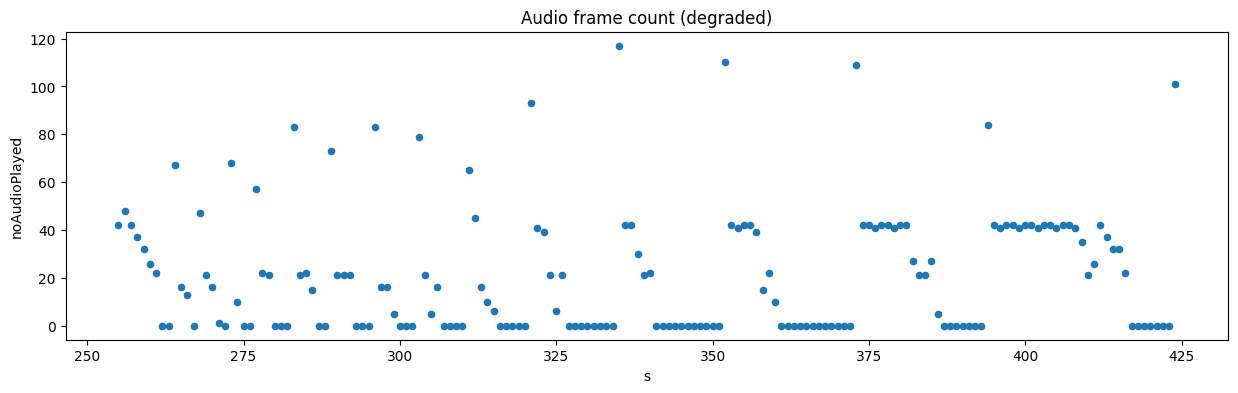

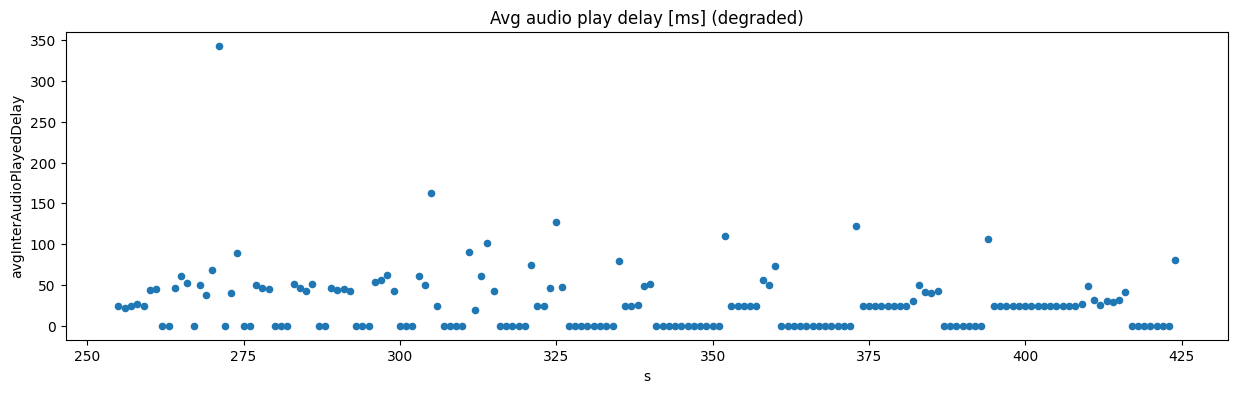

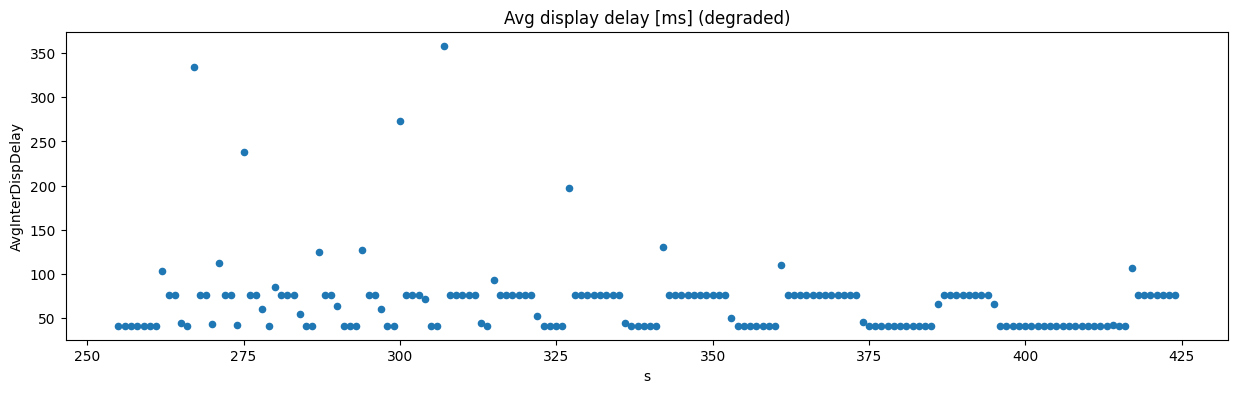

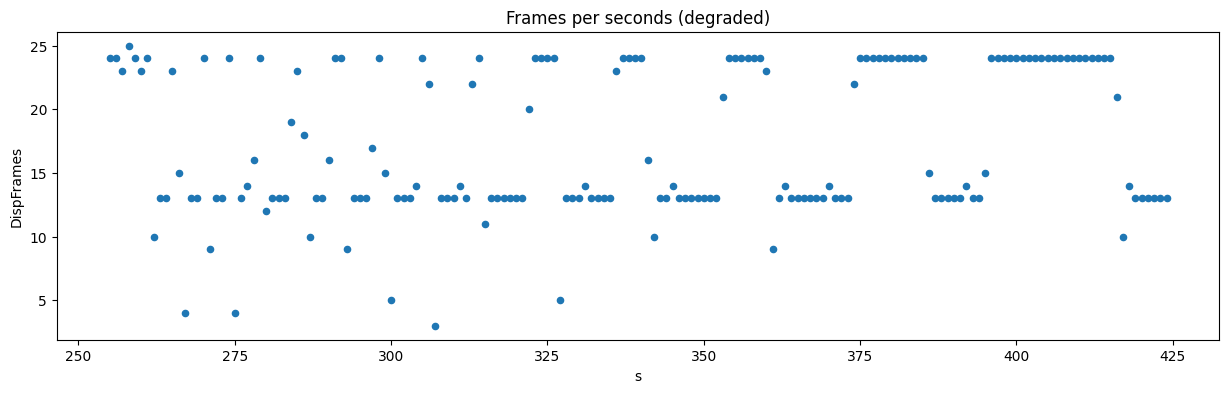

In [250]:
# 255-424, 2630-2727

no_audio = csv_data[255:425].plot.scatter('Unnamed: 0', 'noAudioPlayed', figsize=(15,4))
no_audio.set_title('Audio frame count (degraded)')
no_audio.set_xlabel('s')

audio_delay = csv_data[255:425].plot.scatter('Unnamed: 0', 'avgInterAudioPlayedDelay', figsize=(15,4))
audio_delay.set_title('Avg audio play delay [ms] (degraded)')
audio_delay.set_xlabel('s')

disp_delay = csv_data[255:425].plot.scatter('Unnamed: 0', 'AvgInterDispDelay', figsize=(15,4))
disp_delay.set_title('Avg display delay [ms] (degraded)')
disp_delay.set_xlabel('s')

disp_rate = csv_data[255:425].plot.scatter('Unnamed: 0', 'DispFrames', figsize=(15,4))
disp_rate.set_title('Frames per seconds (degraded)')
disp_rate.set_xlabel('s')


# General plots
Below are shown general plots of the full data for the most important parameters. This summarises the general structure of the data and shows certain outliers for different values and their relation to others.

On this full data representation we can easily see at which times the VOD service is experiencing higher than usual loads due to the flashcrowd modeled traffic.

## Plotted values
I decided to plot the same values that were referenced in the lab task definition, namely:
- noAudioPlayed = Number of audio frames played
- AvgInterAudioPlayedDelay = Average audio play delay
- NetReadAvgDelay = value of network read average delay
- AvgInterDispDelay = Average display delay
- DispFrames = Display Frame Rate (per second)

Text(0.5, 0, 's')

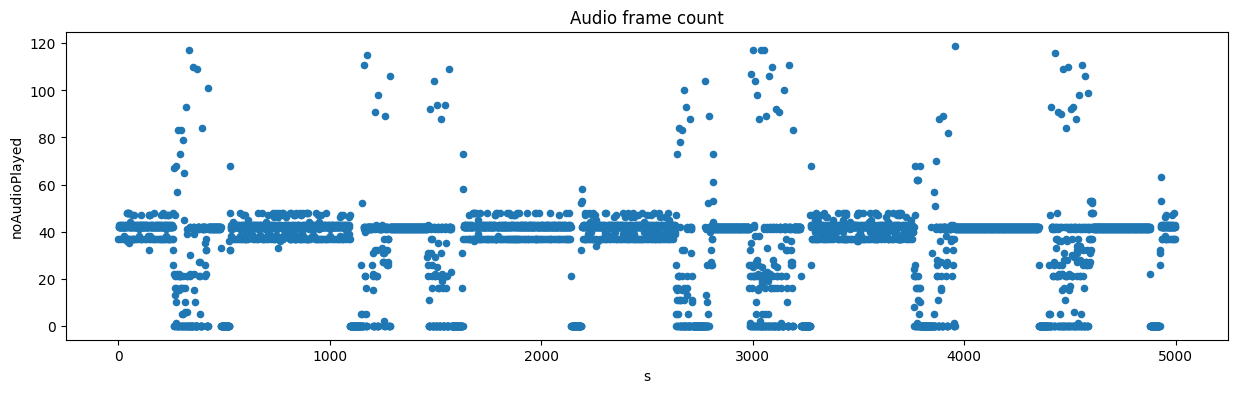

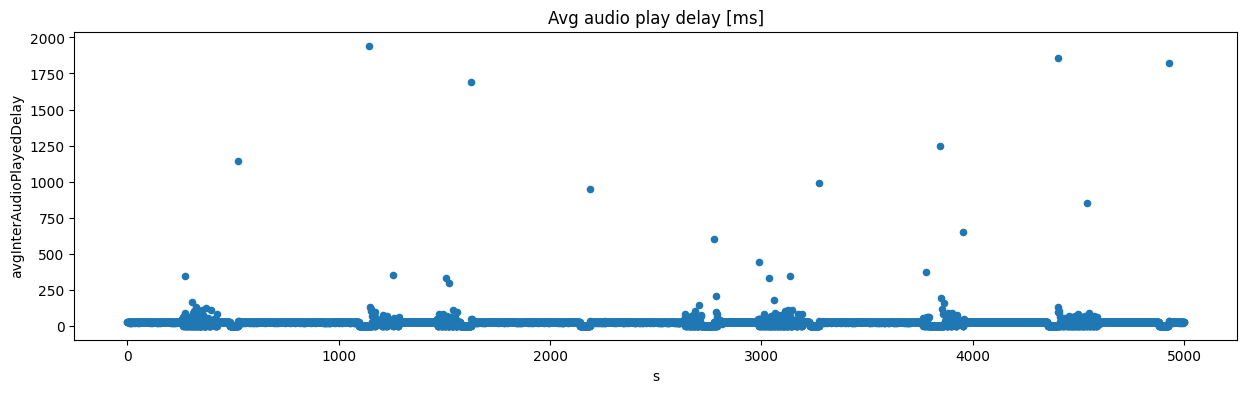

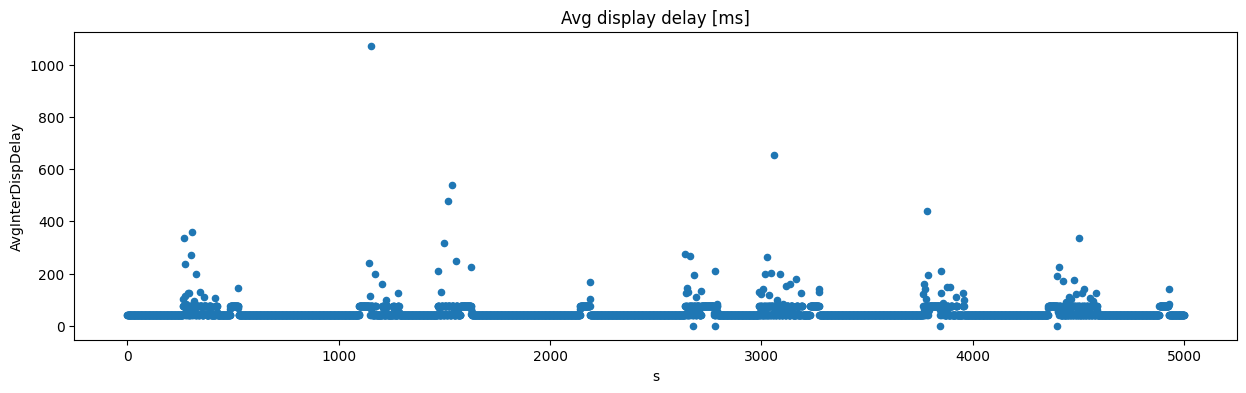

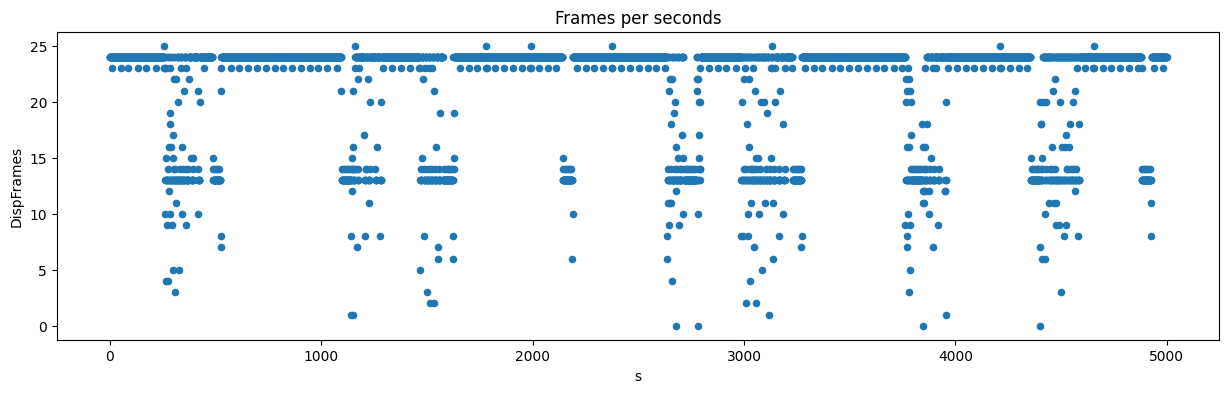

In [251]:
no_audio = csv_data.plot.scatter('Unnamed: 0', 'noAudioPlayed', figsize=(15,4))
no_audio.set_title('Audio frame count')
no_audio.set_xlabel('s')

audio_delay = csv_data.plot.scatter('Unnamed: 0', 'avgInterAudioPlayedDelay', figsize=(15,4))
audio_delay.set_title('Avg audio play delay [ms]')
audio_delay.set_xlabel('s')

disp_delay = csv_data.plot.scatter('Unnamed: 0', 'AvgInterDispDelay', figsize=(15,4))
disp_delay.set_title('Avg display delay [ms]')
disp_delay.set_xlabel('s')

disp_rate = csv_data.plot.scatter('Unnamed: 0', 'DispFrames', figsize=(15,4))
disp_rate.set_title('Frames per seconds')
disp_rate.set_xlabel('s')

To improve the representation of some values, below are presented additional plots without some of the outliers. Presence of outliers in data such as audio and display delay cause the scale of the plot be incorrect. Lower valued values do not get properly represented. Plots below slightly better show smaller variations

(0.0, 400.0)

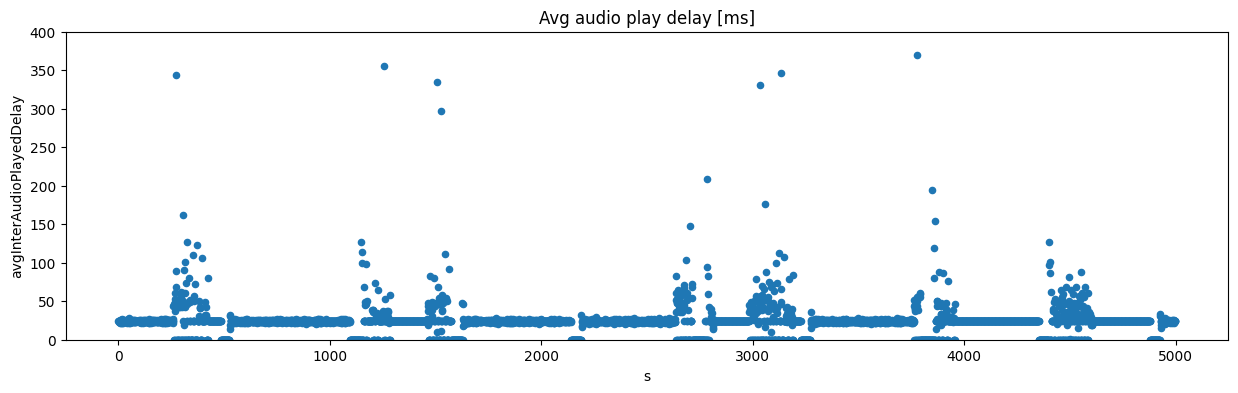

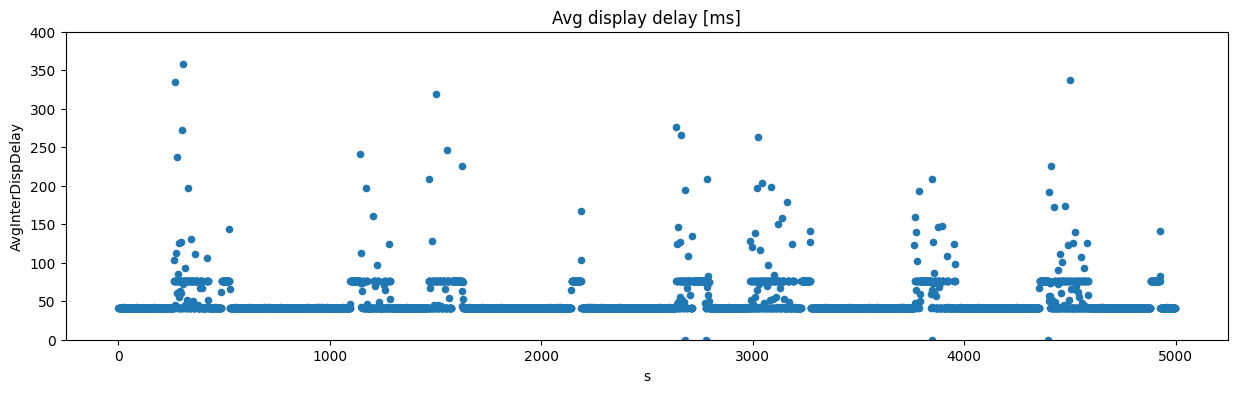

In [252]:
audio_delay = csv_data.plot.scatter('Unnamed: 0', 'avgInterAudioPlayedDelay', figsize=(15,4))
audio_delay.set_title('Avg audio play delay [ms]')
audio_delay.set_xlabel('s')
audio_delay.set_ylim(0, 400)

disp_delay = csv_data.plot.scatter('Unnamed: 0', 'AvgInterDispDelay', figsize=(15,4))
disp_delay.set_title('Avg display delay [ms]')
disp_delay.set_xlabel('s')
disp_delay.set_ylim(0, 400)

## Example detailed outlier analysis - network read delay
Below are shown measured values of average network read delay, for which it was possible to cut the y-axis on the plot without loss of data

To show the importance of outliers, but also not to skip the small variances of typical measurements, I chose to show the data with a cut axis. The code used to do that is largely based on the [example in the official documentation of matplotlib](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html).

It can be seen that the usual values of the delay are sub 50 ms. However, single jumps to very high delays are noticeable. After data analysis it is noticeable that the very high delays occur only after breaks in transmission. This is slightly noticeable on the scatter plot, but more easily seen in direct check of the data entries presented before.

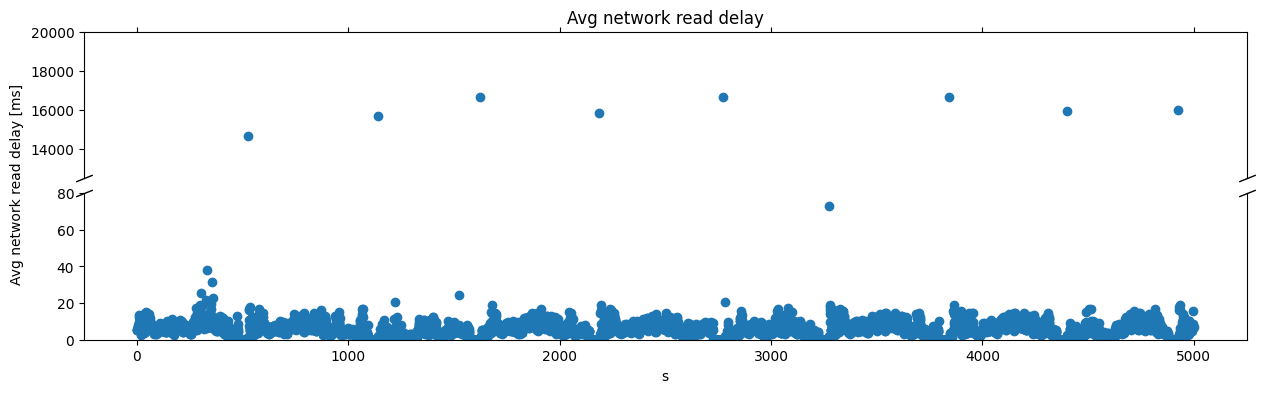

In [253]:
# IMPORTANT: Part of the code is based on the example at:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,4))
fig.subplots_adjust(hspace=0.1)  # Empty space between plot parts
ax1.scatter(csv_data['Unnamed: 0'], csv_data['NetReadAvgDelay'])
ax2.scatter(csv_data['Unnamed: 0'], csv_data['NetReadAvgDelay'])
ax1.set_ylim(12500, 20000)
ax2.set_ylim(0, 80)

# Remove top line of the bottom plot and bottom line of top plot
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# don't put tick labels at the top of the bottom plot
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
# Set the axis break separators
d = 0.4
kwargs = dict(marker=[(-1, -d), (1, d)],
              markersize=12,
              linestyle="none",
              color='k',
              mec='k',
              mew=1,
              clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_title('Avg network read delay')
ax2.set_xlabel('s')
ax1.set_ylabel('Avg network read delay [ms]')
ax1.yaxis.set_label_coords(0.085, 0.5, transform=fig.transFigure)  # Center the y axis label

### Task 2
Use train_test_split() function from sklearn.model_selection package to randomly divide the data into training and testing sets.
Use metrics from "infrastructure-level" dataset as feature variables, and metric (indicated in email) from "service-level" dataset as target variable. Specify size of testing set, e.g. 20%.



---
I read the infr metrics as X (feature variable) and chose the target variable y as the indicated value in the e-mail. The TimeStamp was dropped from X as it should not consitute to the training of the model. The usage of `train_test_split` is typical and should not require much explanation: typical 20% testing set size is used, with a set random_state for result reproducibility

In [254]:
from sklearn.model_selection import train_test_split
X = pd.read_csv('infr-metrics_vod-flashcrowd.csv')
# X.TimeStamp = pd.to_datetime(csv_data.TimeStamp)
X = X.drop('TimeStamp', axis=1)
y = csv_data.avgInterAudioPlayedDelay  # As indicated in the e-mail

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, random_state=4096)  # test_size as proposed

### Task 3
In this step, build your model for prediction of values of the target variable. Try with at least three models:
- RandomForestRegressor from sklearn.ensemble package
- DecisionTreeRegressor from sklearn.tree package
- LinearRegression from sklearn.linear_model package

Assess the accuracy of the trained models using metrics from sklearn.metrics package (for example, mean_absolute_error). Put your conclusions (are your models work OK? Can you predict your target metric using infrastructure metrics?).

You can visualize your results using matplotlib.pyplot package. In case of DecisionTreeRegressor, you can use export_graphviz() function from sklearn.tree to visualize your tree model (or part of it).

Note: don't worry if your model doesn't work perfectly, the data are from a real system 

---
First I will create a helper function to not repeat the code multiple times

In [255]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error  # as proposed by lab instructions


def plot_results(predicted, y_test, model):
    # Check the error of model values vs actual
    mae = mean_absolute_error(y_test, predicted)
    rms_error = root_mean_squared_error(y_test, predicted)
    print(f"MAE = {mae} ms")
    print(f"RMS error = {rms_error} ms")
    
    # Show plots side by side to compare the predictions
    xa = range(1, len(y_test)+1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.scatter(xa, y_test, color='green')
    ax1.set_title('Actual Values - avgInterAudioPlayedDelay')
    ax1.set_ylabel('ms')
    
    ax2.scatter(xa, rf_predicted, color='gray')
    ax2.set_title(f'{model} predictions - avgInterAudioPlayedDelay')
    ax2.set_ylabel('ms')

Then each regressor will be tested with the same methodology. Random state number was chosen semi-randomly

MAE = 9.825705384246339 ms
RMS error = 45.20549128529964 ms


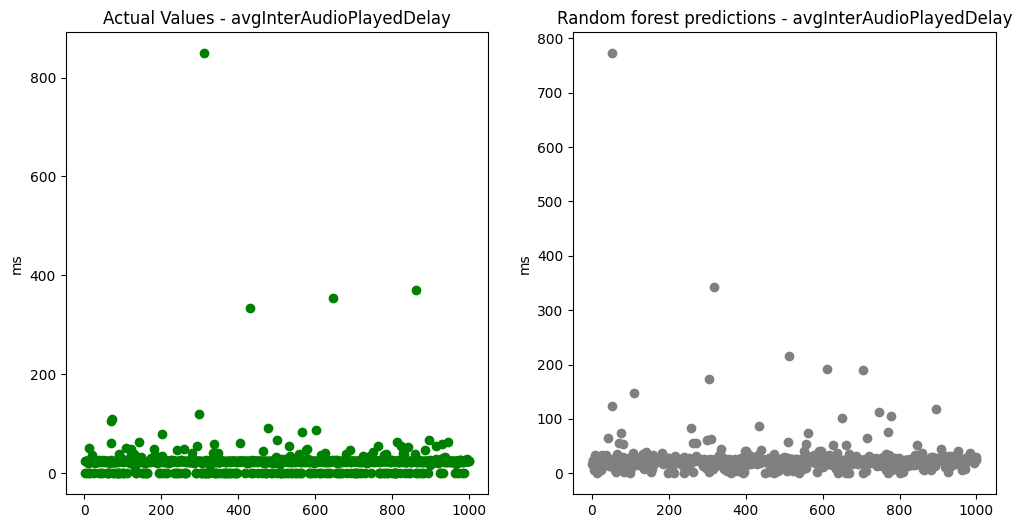

In [256]:
from sklearn.ensemble import RandomForestRegressor

# Create the regressor, fit and train
rf = RandomForestRegressor(random_state=4096)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

plot_results(rf_predicted, y_test, "Random forest")

MAE = 8.712181967310876 ms
RMS error = 50.100697194476524 ms


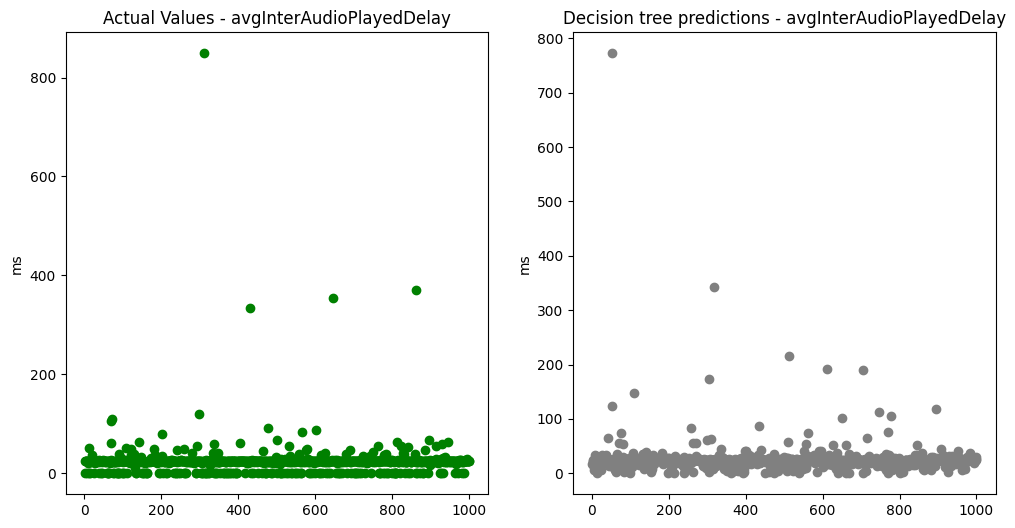

In [257]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
dt = DecisionTreeRegressor(random_state=4096)
dt_fitted = dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
export_graphviz(dt_fitted, 'tst.dot')
plot_results(dt_predicted, y_test, "Decision tree")

MAE = 8.738462835195817 ms
RMS error = 34.1604532293903 ms


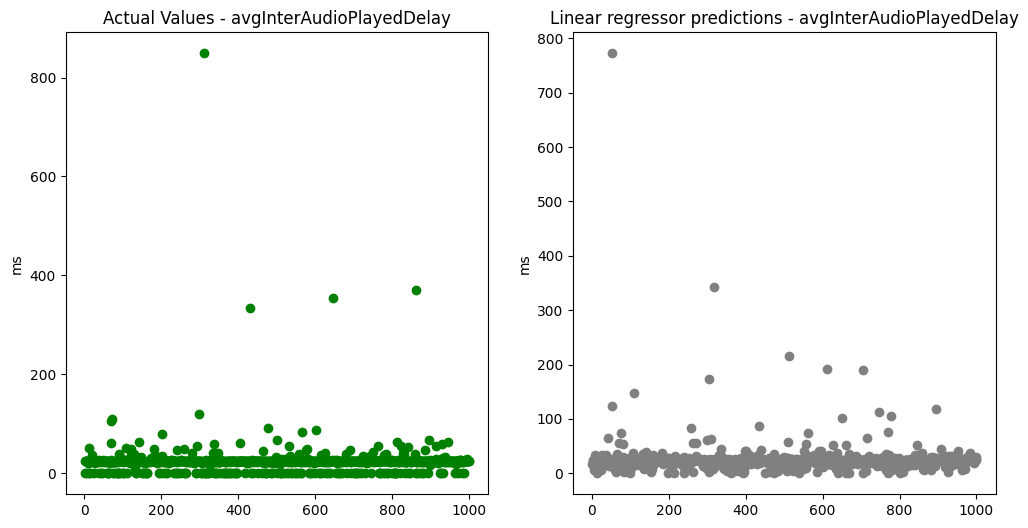

In [258]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predicted = lr.predict(X_test)

plot_results(lr_predicted, y_test, "Linear regressor")

MAE = 7.593371150743339 ms
RMS error = 34.09879952981982 ms


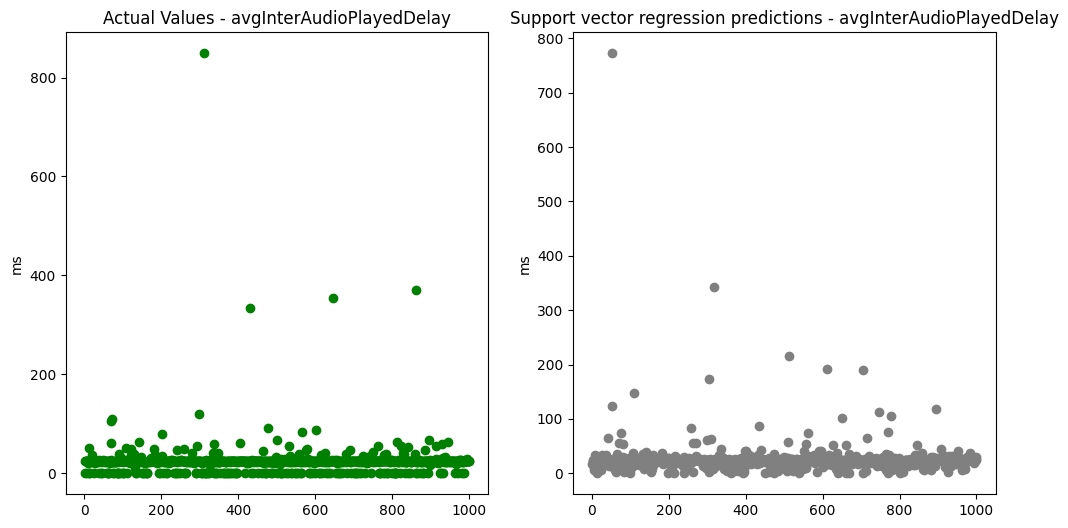

In [259]:
from sklearn.svm import SVR

vec = SVR()
vec.fit(X_train, y_train)
vec_predicted = vec.predict(X_test)

plot_results(vec_predicted, y_test, "Support vector regression")

# Conclusions
4 different regressors were tested. The comparison of the performance by comparison of Mean Absolute Error and Root Mean Squared Error are shown below.

`random_state=4096` for both `train_test_split`, `RandomForestRegressor` and `DecisionTreeRegressor`:

| Model                     | Mean Absolute Error (MAE) [ms] |  Root Mean Squared Error (RMS) [ms] |
|---------------------------|-------------------------------:|------------------------------------:|
| Random Forest Regressor   |                         9.8257 |                             45.2055 |
| Decision Tree Regressor   |                         8.7122 |                             50.1007 |
| Linear Regression         |                         8.7385 |                             34.1605 |
| Support Vector Regression |                         7.5934 |                             34.0988 |

The table shows the models from worst to best. The Support Vector Regressor has the best results, with the lowest MAE. One interesting comparison is Random Forest and Decision Tree. Decision Tree has lower MAE, but higher RMS. This can indicate the ability in handling outliers. In such case, random forest handlers outliers a bit better, but in terms of overall prediction correctness it is worse than random forest.

The outliers created by the flashcrowd traffic model pose a significant impact on the ability of the regressors. They are not predictable by typical models which were checked during this lab. More advanced tuning of parameters or specialised models would be required to better predict outliers.

### Results
All your code and conclusions insert into this file, compile it, and the final version of the file send in a return e-mail. Please remember to rename your file using the following format: ELMET-Laboratory-Name_Surname.ipynb